In [1]:
import os
import time
import json
import numpy as np
from numpy import matlib
import matplotlib.pyplot as plt 
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
from DeepSSMUtils import model
from DeepSSMUtils import losses
from DeepSSMUtils import train_viz
from shapeworks.utils import sw_message
from shapeworks.utils import sw_progress
from shapeworks.utils import sw_check_abort
import warnings
warnings.filterwarnings("ignore")
import os
from glob import glob
import platform
import torch
import random
import numpy as np
import subprocess
import json
from tqdm import tqdm
import shapeworks as sw
import DataAugmentationUtils
import DeepSSMUtils

/anaconda/envs/shapeworks/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/anaconda/envs/shapeworks/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  meth

In [ ]:
import os


In [2]:
explained_var = 90
train_loader = torch.load(
    f'../dataset/All/Ventricles_64_3_cleaned/DeepSSM_rw1/torch_loaders{explained_var}/train', 
)
val_loader = torch.load(
    f'../dataset/All/Ventricles_64_3_cleaned/DeepSSM_rw1/torch_loaders{explained_var}/validation', 
)

In [3]:
DEVICE = 'cuda'
explained_var = 90
config_file = f'../dataset/All/Ventricles_64_3_cleaned/DeepSSM_rw1/DeepSSM{explained_var}.json'
net = model.DeepSSMNet(config_file)
net.load_state_dict(
    torch.load(
        f'../dataset/All/Ventricles_64_3_cleaned/DeepSSM_rw1/DeepSSM{explained_var}/best_model.torch',
    )
)
for param in net.parameters():
    param.requires_grad = False
net.to(DEVICE)
net.eval();

MLP layers: 192 -> 96 -> 48 -> 23


In [6]:
# train:    (0.5948880372851875, 0.24535532309374677)
# val:      (0.7765622819782397, 0.4438534944976142)
# val mean au: 0.6223745936647468
# val mean eu: 0.769389968126192
#
aus, eus = [], []
loader = val_loader
for img, pca, mdl in tqdm(loader):
    img = img.to(DEVICE)
    pca = pca.to(DEVICE)
    mdl = mdl.to(DEVICE)
    [mu, v, alpha, beta], pred_mdl = net(img)
    au = (beta / (alpha - 1)).mean().item() 
    eu = (beta / (v * (alpha - 1))).mean().item()
    aus.append(au)
    eus.append(eu)

100%|██████████| 109/109 [00:02<00:00, 46.75it/s]


In [29]:
for threshold in np.linspace(0, 1, 11):
    aus, eus = [], []
    for _ in range(109):
        img = torch.rand(1, 1, 64, 64, 64)
        img = img = (img > threshold).float().to(DEVICE)
        [mu, v, alpha, beta], pred_mdl = net(img)
        au = (beta / (alpha - 1)).mean().item() 
        eu = (beta / (v * (alpha - 1))).mean().item()
        aus.append(au)
        eus.append(eu)
    print(f'threshold: {threshold}')
    print(f'Mean AU: {np.mean(aus)}')
    print(f'Mean EU: {np.mean(eus)}\n')

threshold: 0.0
Mean AU: 0.8326398653721591
Mean EU: 1.4714468072313782

threshold: 0.1
Mean AU: 1.1167246393107493
Mean EU: 7.3251694320538725

threshold: 0.2
Mean AU: 1.5439566953466572
Mean EU: 24.745871972600256

threshold: 0.30000000000000004
Mean AU: 1.7415634874903827
Mean EU: 33.829592591031975

threshold: 0.4
Mean AU: 1.9274511085737736
Mean EU: 34.81520728015025

threshold: 0.5
Mean AU: 2.0344065974611754
Mean EU: 25.319916628916328

threshold: 0.6000000000000001
Mean AU: 2.0131881422952773
Mean EU: 16.1954513558554

threshold: 0.7000000000000001
Mean AU: 1.846233098878773
Mean EU: 9.380124667368898

threshold: 0.8
Mean AU: 1.4991010941496683
Mean EU: 4.928198455670558

threshold: 0.9
Mean AU: 1.1168724314882121
Mean EU: 2.4027364603970027

threshold: 1.0
Mean AU: 0.9325690865516663
Mean EU: 1.3581233024597168



In [12]:
img.shape

torch.Size([1, 1, 64, 64, 64])

In [16]:
val_scores = np.load('../dataset/All/Ventricles_64_3_cleaned/DeepSSM_rw1/torch_loaders90/val_pca_scores.npy')
val_scores.shape

(109, 23)

In [23]:
temp = np.zeros((109, 23))
for i, (img, pca, mdl) in enumerate(tqdm(val_loader)):
    temp[i] = pca.numpy()

100%|██████████| 109/109 [00:00<00:00, 186.83it/s]


In [25]:
temp.shape

(109, 23)

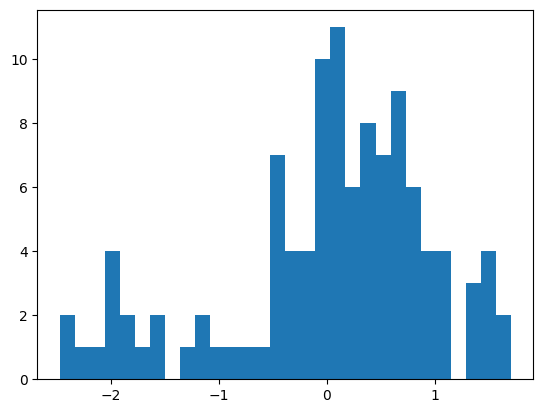

In [27]:
plt.hist(val_scores[:, 0].flatten(), bins=30)
plt.show()

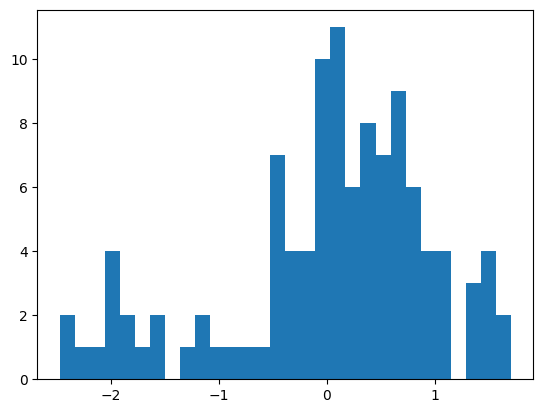

In [26]:
plt.hist(temp[:, 0].flatten(), bins=30)
plt.show()